Generating 2000 synthetic urban data samples...
Synthetic data generation complete.

Training data shape: (1600, 6)
Testing data shape: (400, 6)
Building and training the MLP model...
Model training complete.
Evaluating model performance...

--- Model Evaluation ---
Mean Absolute Error (MAE): 1.31 °C
R-squared (R2) Score: 0.48
------------------------


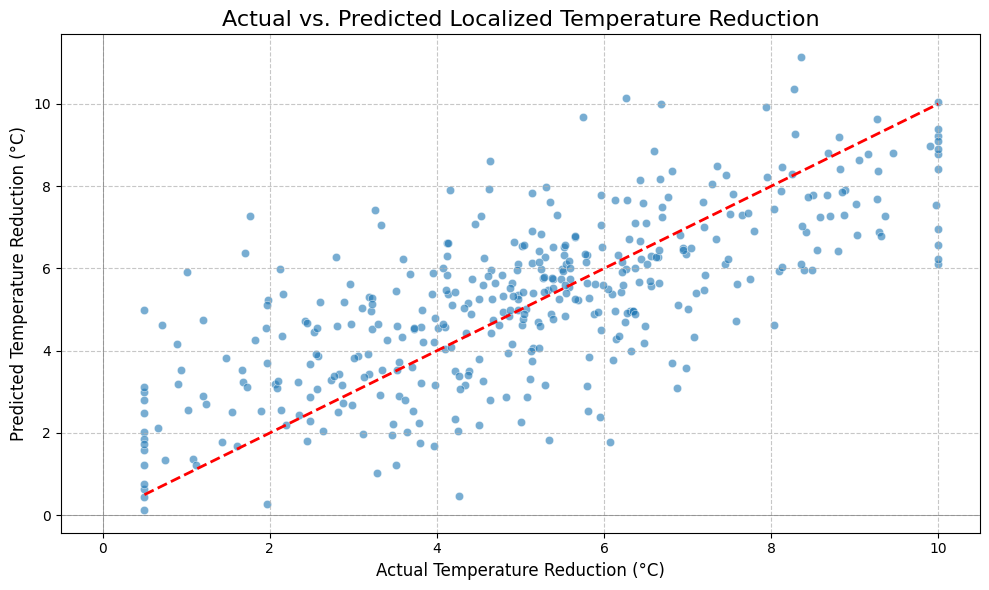


Features used in the model:
- building_height
- existing_green_area_pct
- albedo_index
- wind_exposure_index
- proposed_tree_density
- proposed_green_roof_area_pct

--- Making a new prediction for a hypothetical urban block ---
Input parameters for new block: {'building_height': 30.0, 'existing_green_area_pct': 0.1, 'albedo_index': 0.3, 'wind_exposure_index': 0.5, 'proposed_tree_density': 40.0, 'proposed_green_roof_area_pct': 0.25}
Predicted localized temperature reduction for this block: 8.18 °C

Input parameters for second new block: {'building_height': 30.0, 'existing_green_area_pct': 0.1, 'albedo_index': 0.7, 'wind_exposure_index': 0.5, 'proposed_tree_density': 5.0, 'proposed_green_roof_area_pct': 0.01}
Predicted localized temperature reduction for this block: 2.83 °C


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set a random seed for reproducibility
np.random.seed(42)

def generate_synthetic_urban_data(num_samples=1000):
    """
    Generates synthetic data for urban microclimate prediction.
    This function simulates various urban parameters and their hypothetical
    impact on localized temperature reduction.

    Args:
        num_samples (int): The number of synthetic urban blocks to generate.

    Returns:
        pd.DataFrame: A DataFrame containing simulated urban features and
                      the target variable (temperature reduction).
    """
    print(f"Generating {num_samples} synthetic urban data samples...")

    # Define ranges for urban features
    building_height = np.random.uniform(5, 50, num_samples) # meters
    existing_green_area_pct = np.random.uniform(0, 0.4, num_samples) # percentage of area
    albedo_index = np.random.uniform(0.1, 0.9, num_samples) # reflectivity of surfaces
    wind_exposure_index = np.random.uniform(0.1, 1.0, num_samples) # 0.1 (sheltered) to 1.0 (exposed)
    proposed_tree_density = np.random.uniform(0, 50, num_samples) # trees per urban block
    proposed_green_roof_area_pct = np.random.uniform(0, 0.3, num_samples) # percentage of roof area

    # Simulate baseline temperature (e.g., during a heatwave)
    # This is the temperature without any specific greening intervention
    baseline_temperature = np.random.uniform(30, 40, num_samples) # degrees Celsius

    # Simulate temperature reduction based on features
    # This is a simplified, hypothetical relationship for demonstration
    # In a real project, this would be learned from complex data/simulations
    temp_reduction = (
        (existing_green_area_pct * 5) + # More green area, more reduction
        (proposed_tree_density * 0.1) + # More trees, more reduction
        (proposed_green_roof_area_pct * 8) + # Green roofs have a good impact
        ((1 - albedo_index) * 3) - # Lower albedo (darker surfaces), less reduction (or higher temp)
        (wind_exposure_index * 2) + # Higher wind exposure, slightly more reduction due to convection
        np.random.normal(0, 1.5, num_samples) # Add some random noise
    )

    # Ensure temperature reduction is positive (actual cooling) and within a reasonable range
    temp_reduction = np.clip(temp_reduction, 0.5, 10.0) # Min 0.5 deg C reduction, max 10 deg C

    data = pd.DataFrame({
        'building_height': building_height,
        'existing_green_area_pct': existing_green_area_pct,
        'albedo_index': albedo_index,
        'wind_exposure_index': wind_exposure_index,
        'proposed_tree_density': proposed_tree_density,
        'proposed_green_roof_area_pct': proposed_green_roof_area_pct,
        'baseline_temperature': baseline_temperature,
        'predicted_temp_reduction': temp_reduction # This is our target variable
    })
    print("Synthetic data generation complete.")
    return data

def build_and_train_model(X_train, y_train):
    """
    Builds and trains a simple Multi-layer Perceptron (Neural Network) regressor.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.

    Returns:
        MLPRegressor: The trained MLP model.
        StandardScaler: The fitted scaler for features.
    """
    print("Building and training the MLP model...")

    # Scale features for better neural network performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Define the MLP Regressor model
    # You can experiment with different hidden_layer_sizes, activation functions, etc.
    model = MLPRegressor(
        hidden_layer_sizes=(100, 50), # Two hidden layers with 100 and 50 neurons
        activation='relu',            # Rectified Linear Unit activation function
        solver='adam',                # Adam optimizer
        max_iter=1000,                # Maximum number of iterations (epochs)
        random_state=42,
        verbose=False                 # Set to True for training progress output
    )

    # Train the model
    model.fit(X_train_scaled, y_train)
    print("Model training complete.")
    return model, scaler

def evaluate_and_visualize(model, scaler, X_test, y_test):
    """
    Evaluates the trained model and visualizes its predictions.

    Args:
        model (MLPRegressor): The trained MLP model.
        scaler (StandardScaler): The fitted scaler used for features.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
    """
    print("Evaluating model performance...")

    # Scale the test features using the same scaler fitted on training data
    X_test_scaled = scaler.transform(X_test)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n--- Model Evaluation ---")
    print(f"Mean Absolute Error (MAE): {mae:.2f} °C")
    print(f"R-squared (R2) Score: {r2:.2f}")
    print(f"------------------------")

    # Visualization of Actual vs. Predicted Temperature Reduction
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Ideal line
    plt.title('Actual vs. Predicted Localized Temperature Reduction', fontsize=16)
    plt.xlabel('Actual Temperature Reduction (°C)', fontsize=12)
    plt.ylabel('Predicted Temperature Reduction (°C)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(0, color='grey', lw=0.5)
    plt.axvline(0, color='grey', lw=0.5)
    plt.tight_layout()
    plt.show()

    # Feature Importance (for tree-based models, less direct for MLPs but can be inferred)
    # For MLPs, you might analyze weights or use permutation importance (more complex)
    # For this example, we'll just print the feature names
    print("\nFeatures used in the model:")
    for i, col in enumerate(X_test.columns):
        print(f"- {col}")


if __name__ == "__main__":
    # 1. Generate Synthetic Data
    urban_data = generate_synthetic_urban_data(num_samples=2000)

    # Define features (X) and target (y)
    # We exclude 'baseline_temperature' from features as we are predicting the *reduction*
    # based on design, not the absolute temperature.
    features = [
        'building_height', 'existing_green_area_pct', 'albedo_index',
        'wind_exposure_index', 'proposed_tree_density', 'proposed_green_roof_area_pct'
    ]
    target = 'predicted_temp_reduction'

    X = urban_data[features]
    y = urban_data[target]

    # 2. Split Data into Training and Testing Sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"\nTraining data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")

    # 3. Build and Train the Model
    model, scaler = build_and_train_model(X_train, y_train)

    # 4. Evaluate and Visualize
    evaluate_and_visualize(model, scaler, X_test, y_test)

    # --- Example of making a new prediction ---
    print("\n--- Making a new prediction for a hypothetical urban block ---")
    # Scenario: A new urban block with high proposed greening
    new_urban_block_data = pd.DataFrame([[
        30,   # building_height (medium)
        0.1,  # existing_green_area_pct (low)
        0.3,  # albedo_index (darker surfaces)
        0.5,  # wind_exposure_index (moderate)
        40,   # proposed_tree_density (high)
        0.25  # proposed_green_roof_area_pct (high)
    ]], columns=features)

    # Scale the new data using the same scaler
    new_urban_block_scaled = scaler.transform(new_urban_block_data)
    predicted_reduction = model.predict(new_urban_block_scaled)[0]

    print(f"Input parameters for new block: {new_urban_block_data.iloc[0].to_dict()}")
    print(f"Predicted localized temperature reduction for this block: {predicted_reduction:.2f} °C")

    # Scenario 2: A new urban block with minimal proposed greening
    new_urban_block_data_2 = pd.DataFrame([[
        30,   # building_height (medium)
        0.1,  # existing_green_area_pct (low)
        0.7,  # albedo_index (lighter surfaces)
        0.5,  # wind_exposure_index (moderate)
        5,    # proposed_tree_density (low)
        0.01  # proposed_green_roof_area_pct (very low)
    ]], columns=features)

    new_urban_block_scaled_2 = scaler.transform(new_urban_block_data_2)
    predicted_reduction_2 = model.predict(new_urban_block_scaled_2)[0]

    print(f"\nInput parameters for second new block: {new_urban_block_data_2.iloc[0].to_dict()}")
    print(f"Predicted localized temperature reduction for this block: {predicted_reduction_2:.2f} °C")
